# Analysis of Ariane Qualitative Runs

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt, animation
import xarray as xr
import numpy as np
import pandas as pd
import cmocean as cm
from datetime import datetime
from IPython.display import HTML
import netCDF4 as nc
from cartopy import crs, feature

## test run with SalishSeaCast

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/salish_qual/forward_01mar19/ariane_trajectories_qualitative.nc')

Text(0, 0.5, 'lat')

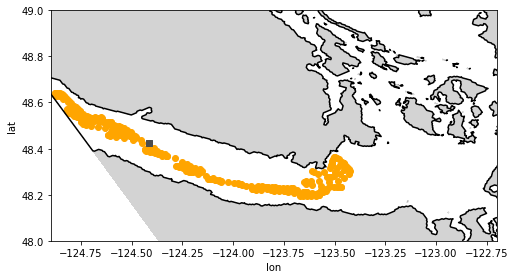

In [3]:
# 2D
fig, ax = plt.subplots(1,1,figsize=(8,4.6))

ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.9, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)

ax.scatter(file.traj_lon,file.traj_lat,color='orange')
ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s')

ax.set_xlabel('lon')
ax.set_ylabel('lat')

In [4]:
file.traj_lon[0],file.traj_lat[0]

(<xarray.DataArray 'traj_lon' (ntraj: 1)>
 array([-124.416718])
 Dimensions without coordinates: ntraj
 Attributes:
     title:     What is traj_lon ?
     longname:  Trajectory: x positions
     units:     No dimension,
 <xarray.DataArray 'traj_lat' (ntraj: 1)>
 array([48.423752])
 Dimensions without coordinates: ntraj
 Attributes:
     title:     What is traj_lat ?
     longname:  Trajectory: y positions
     units:     No dimension)

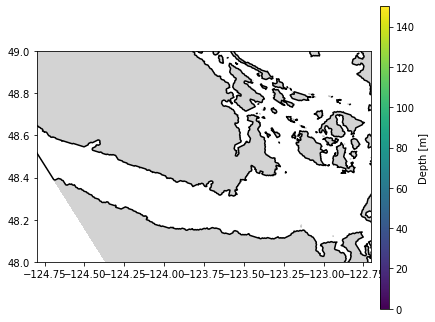

In [4]:
# Make initial animation figure
fig, ax = plt.subplots(figsize=(6, 6))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=150, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
    l.set_offsets(np.vstack([file.traj_lon[hour,:], file.traj_lat[hour,:]]).T)
    l.set_array(file.traj_depth[hour,:])
    return l,t ,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(file.nb_output)-1, interval=100, blit=True)

In [5]:
HTML(anim.to_html5_video())

## CIOPS BC12
#### first: lets make some smart choices about where to put the particles!

In [2]:
# date = datetime(2016,1,1)
# nc_file = "/ocean/rbeutel/data/{:%Y%m}/U_new_{:%Y%m%d}.nc".format(date,date)
nc_file = "/ocean/rbeutel/data/201701/U_new_20170101.nc"
nc_to_plot = xr.open_dataset(nc_file)
mesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

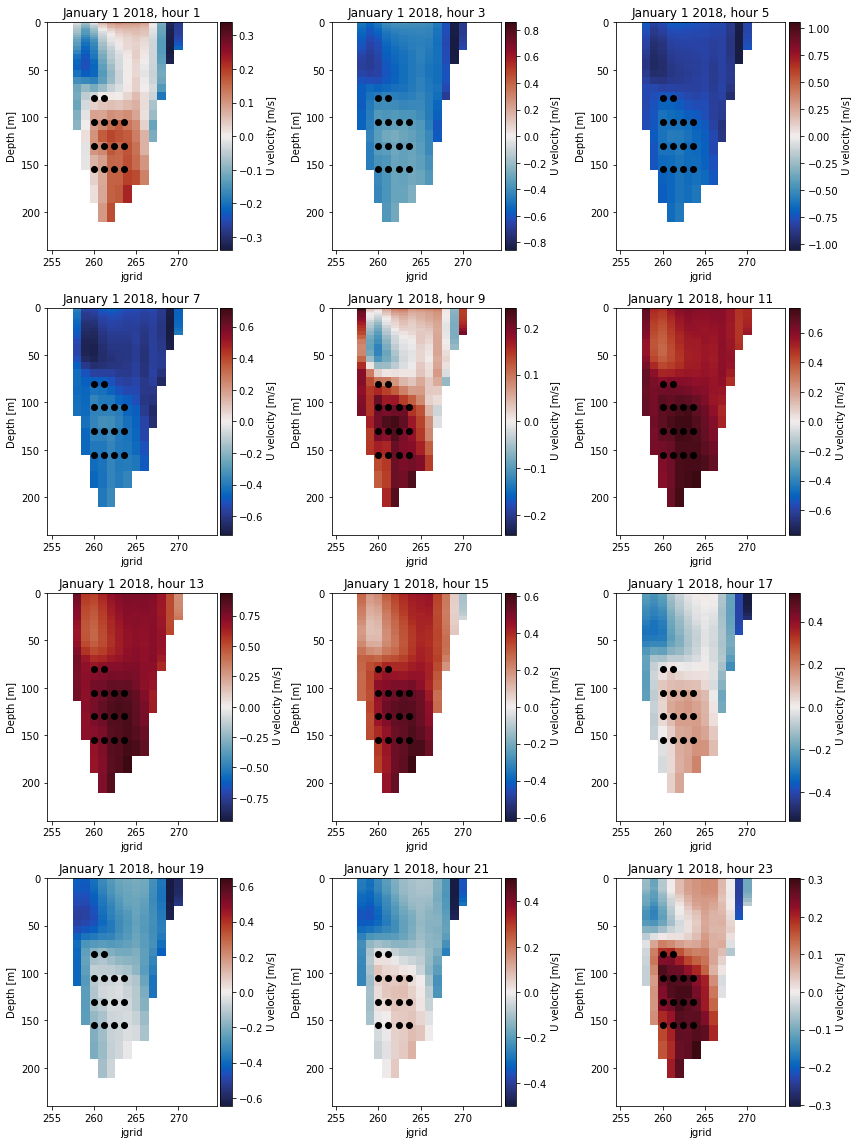

In [4]:
# nc_file = "/ocean/rbeutel/data/{:%Y%m}/U_new_{:%Y%m%d}.nc".format(date,date)
nc_to_plot = nc.Dataset(nc_file)
mesh_nc = nc.Dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

# hours = [0, 3, 6, 12, 15, 18, 21, 24]
hours = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]

variable = 'vozocrtx'
fig, ax= plt.subplots(nrows=4, ncols=3, figsize =(12,16))

igrid = 646-1
latS = 255
latN = 275
k = 0

for hour in hours:
    data = nc_to_plot[variable][hour,:,latS:latN,igrid]
    # X, Y = np.meshgrid(nc_to_plot['nav_lat'][646,255:273], nc_to_plot['depthu'])
    section_slice = np.arange(latS,latN)
    zlevels = mesh_nc['gdept_1d'][:][0]
    X, Y = np.meshgrid(section_slice, zlevels)
    tmesh = ax[hour//6,k].pcolormesh(X,Y,data, cmap = cm.cm.balance, \
                          vmin = -1 * np.max(np.abs(data)), vmax = np.max(np.abs(data)))

    ax[hour//6,k].set_ylim([0,240])
    ax[hour//6,k].invert_yaxis()
    ax[hour//6,k].set_ylabel('Depth [m]')
    ax[hour//6,k].set_xlabel('jgrid')
    ax[hour//6,k].set_title('January 1 2018, hour '+str(hour+1))
    
    cbar = fig.colorbar(tmesh, ax=ax[hour//6,k], orientation = 'vertical',fraction=0.08, pad=0.02)#, ticks = tticks)
    cbar.set_label(label=' U velocity [m/s]') 
    
    # particle location evenly arangedthrough lower half of water column
#     ax[hour//6,k].scatter([260,260,260,262.3,262.3,262.3,262.3,264.7,264.7,264.7,264.7,267,267,267],[90,120,150, 90,120, 150, 180, 90,120, 150, 180,90, 120, 150],c='k')
    # particle location focused in area of high influx (from SSC JR CSs)
    ax[hour//6,k].scatter([260,260,260,260,261.2,261.2,261.2,261.2,262.4,262.4,262.4,263.6,263.6,263.6],[80,105,130,155,80,105,130,155,105,130,155,105,130,155],c='k')
    #once i get CIOPS to work i honestly think i should do both particle location schemes
    
    if k ==2:
        k = 0
    else:
        k +=1 
    
plt.tight_layout()

# ax[1].scatter([261,261,261,263.5,263.5,263.5,263.5,266,266,266],[90,120,150, 90,120, 150, 180, 90, 120, 150],c='k')

In [10]:
#now for ariane you cannot set the position at a depth of 90 bc that will put it incell 90 (which doesn't exist)
#instead find with depth grid cell that best corresponds with the positions you chose above
[(x,y) for (x,y) in enumerate(zlevels)]

[(0, 0.507530023512452),
 (1, 1.557569488842656),
 (2, 2.6693409194084996),
 (3, 3.857884935301262),
 (4, 5.141913831146915),
 (5, 6.544535333853228),
 (6, 8.093971465979628),
 (7, 9.824157673695284),
 (8, 11.775044353140647),
 (9, 13.992364711100425),
 (10, 16.52661505451083),
 (11, 19.43106879090391),
 (12, 22.758861118719427),
 (13, 26.559531476793033),
 (14, 30.875785062827266),
 (15, 35.74142752531527),
 (16, 41.181253706626364),
 (17, 47.21313511579986),
 (18, 53.85189559955382),
 (19, 61.11412039354691),
 (20, 69.02298960174267),
 (21, 77.61249605846115),
 (22, 86.93079063628434),
 (23, 97.04271072951805),
 (24, 108.03171341445899),
 (25, 120.0014691078047),
 (26, 133.0773268246376),
 (27, 147.4077864359136),
 (28, 163.16603544640805),
 (29, 180.55153922041305),
 (30, 199.79161550620404),
 (31, 221.14287374964496),
 (32, 244.8923539986389),
 (33, 271.3581577853082),
 (34, 300.8893252934304),
 (35, 333.8646831888884),
 (36, 370.6903722478645),
 (37, 411.79577220550027),
 (38, 457

SO 90 m=22, 120 m=25, 150 m=27, and 180 m=29

In [2]:
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/forward_01mar17/ariane_trajectories_qualitative.nc')

Text(0, 0.5, 'lat')

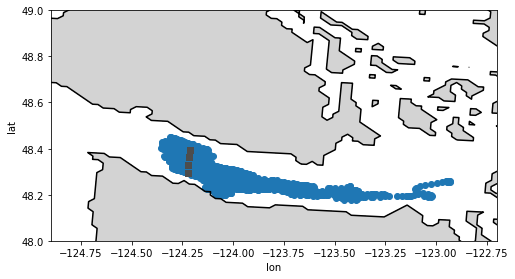

In [12]:
# 2D
fig, ax = plt.subplots(1,1,figsize=(8,4.6))

ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.9, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)

ax.scatter(file.traj_lon,file.traj_lat)
ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s')

ax.set_xlabel('lon')
ax.set_ylabel('lat')

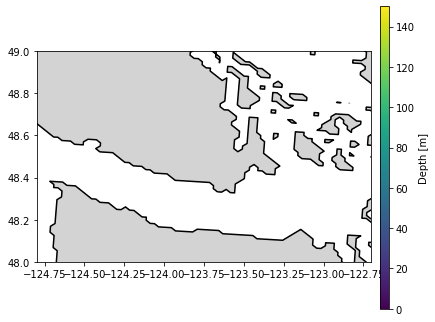

In [13]:
# Make initial animation figure
fig, ax = plt.subplots(figsize=(6, 6))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=150, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
#     tstamp = file.traj_time[hour, 0].values.astype('datetime64[s]').astype(datetime)
#     t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l.set_offsets(np.vstack([file.traj_lon[hour,:], file.traj_lat[hour,:]]).T)
    l.set_array(file.traj_depth[hour,:])
    return l, t,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(file.nb_output)-1, interval=100, blit=True)

In [14]:
HTML(anim.to_html5_video())

In [15]:
file.traj_depth[:,0]

<xarray.DataArray 'traj_depth' (nb_output: 241)>
array([-102.421585, -100.559929, -102.398514, ...,  -77.736279,  -75.82184 ,
        -76.703534])
Dimensions without coordinates: nb_output
Attributes:
    title:     What is traj_depth ?
    longname:  Trajectory: z positions
    units:     No dimension

### now with backwards!?

In [26]:
def plt_qual_2D(month, year,ax):
    
    n = 14 #number of particles being tracked
    
    if month == 'feb':
        file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/backward_28'+month+str(year)+'/ariane_trajectories_qualitative.nc')
    else:
        file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/backward_30'+month+str(year)+'/ariane_trajectories_qualitative.nc')
    
    # Bathymetry
    c = ax.contourf(
    mesh.nav_lon, mesh.nav_lat, mesh.mbathy[0,:,:]*10, levels=np.arange(0, 500.1, 5),
    cmap=cm.cm.deep, extend='max',zorder=0,
    )
    
    # "Mapping"
    ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
    ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',zorder=2)
    ax.set_xlim([-126.7, -123.7])
    ax.set_ylim([47.5, 49.5])
    ax.set_aspect(1/np.sin(np.deg2rad(49)))
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.set_title(month, fontsize=16)
    
    # Particle trajectories and depth
    im = ax.scatter(file.traj_lon,file.traj_lat, c=file.traj_depth, vmax=0, vmin=-350, cmap=cm.cm.solar, s=10,zorder=3)
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
    ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s', zorder=4) # start location
    
    # End locations
    last_point= [pd.DataFrame(file.traj_lat[:,i]).last_valid_index() for i in range(n)]
    for i in range(n):
        ax.scatter(file.traj_lon[last_point[i],i],file.traj_lat[last_point[i],i],color='r',marker='*', zorder=4)

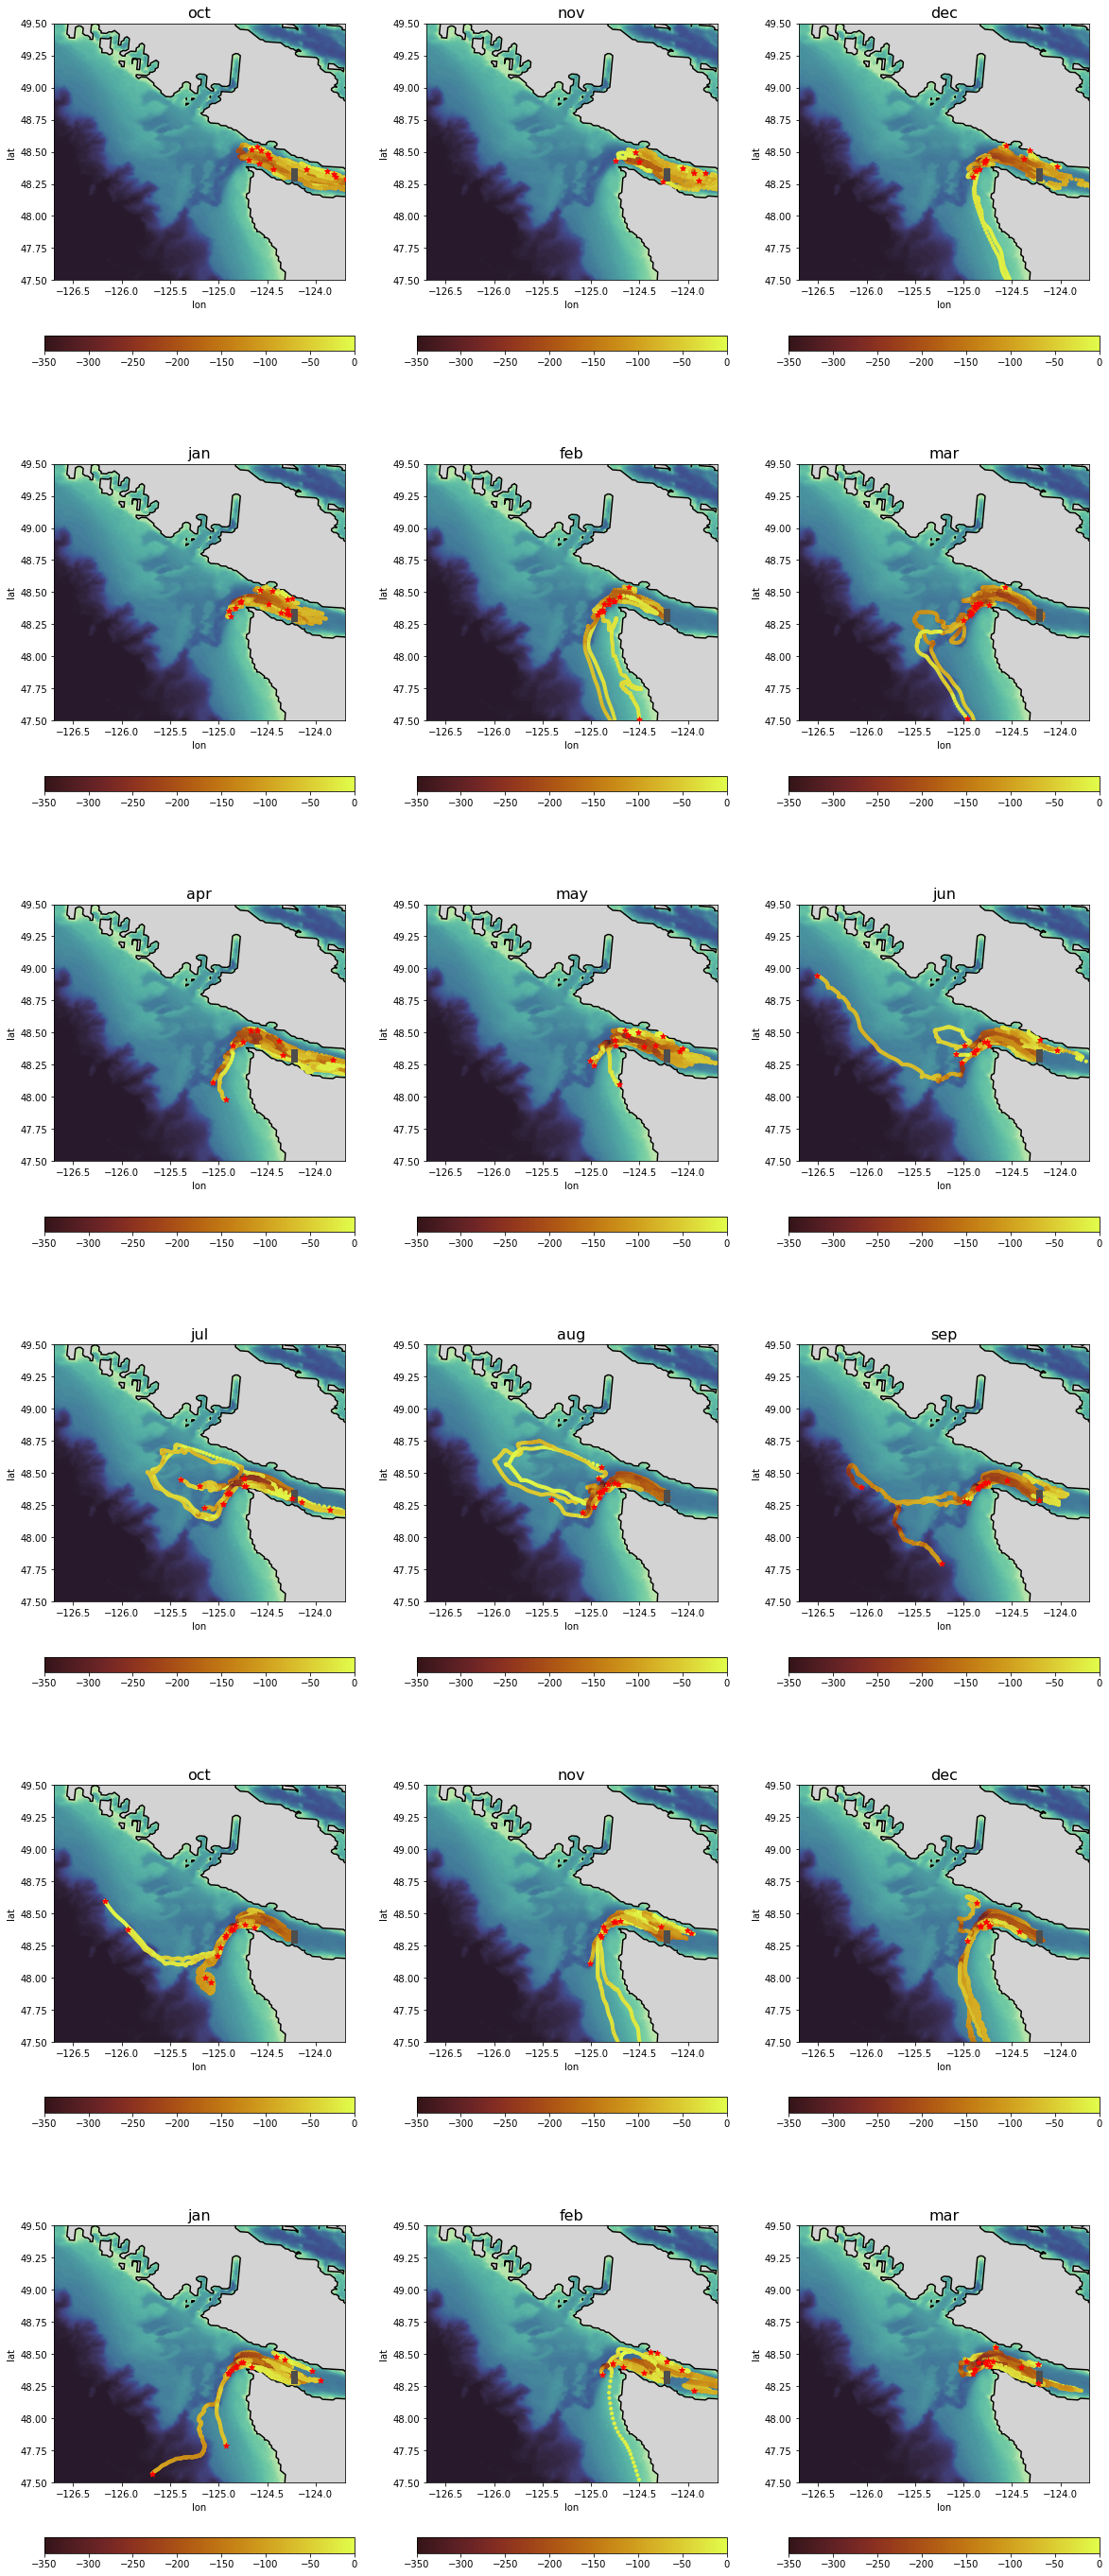

In [27]:
fig, ax = plt.subplots(6,3,figsize=(20, 50))

plt_qual_2D('oct', 16, ax[0,0])
plt_qual_2D('nov', 16, ax[0,1])
plt_qual_2D('dec', 16, ax[0,2])

plt_qual_2D('jan', 17, ax[1,0])
plt_qual_2D('feb', 17, ax[1,1])
plt_qual_2D('mar', 17, ax[1,2])
plt_qual_2D('apr', 17, ax[2,0])
plt_qual_2D('may', 17, ax[2,1])
plt_qual_2D('jun', 17, ax[2,2])
plt_qual_2D('jul', 17, ax[3,0])
plt_qual_2D('aug', 17, ax[3,1])
plt_qual_2D('sep', 17, ax[3,2])
plt_qual_2D('oct', 17, ax[4,0])
plt_qual_2D('nov', 17, ax[4,1])
plt_qual_2D('dec', 17, ax[4,2])

plt_qual_2D('jan', 18, ax[5,0])
plt_qual_2D('feb', 18, ax[5,1])
plt_qual_2D('mar', 18, ax[5,2])

### summer expected: 
* california undercurrent only important in the summer (shifted further offshore in the winter) <br>
* CUC important during upwellig in the summer in the area over the continental slope <br>
* definitely need the boundaries to not overlap with the area taken up by JdF eddy - so further offshore

### winter expected:
* Davidson replaces CUC in the 100 km closest to the shore in the winter
* all the stuff pushed further offshore

maybe i need to run for longer, the runs like october aren't that useful.<br>

for the first round(s) of running have the whole pacific boundary as one boundary so that you can look at it all at once and see if there are distinct areas of water coming in/different tracer characteristisc (although couldn't you jsut do this by looking at cross-sections from the model output itself instead of having to runing ariane, except you woulndt only be looking at the stuff that gets in JdF..? think about this) and then afetr that split up the boundary like the did in Schmitt 2021 figure 1 a based on the liekyltrack of different sources. 

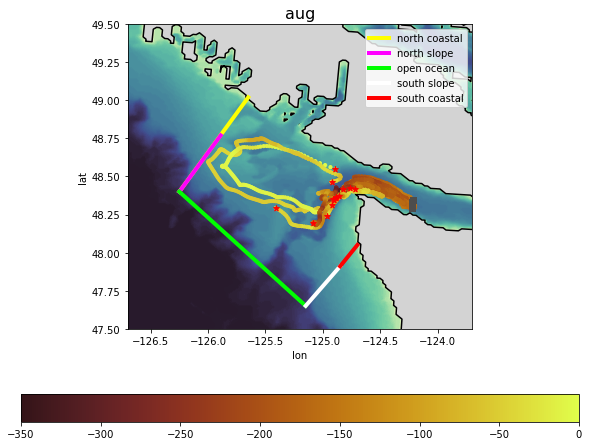

In [5]:
# summer boundaries
fig, ax = plt.subplots(figsize=(10,8))
plt_qual_2D('aug', ax)
ax.plot([-126.25,-125.65],[48.4,49.02], c='yellow', linewidth=4, label='north coastal')
ax.plot([-126.25,-125.89],[48.4,48.77], c='magenta',linewidth=4, label='north slope')
ax.plot([-126.25,-125.15],[48.4,47.65], c='lime',linewidth=4, label='open ocean')
ax.plot([-124.85,-125.15],[47.91,47.65], c='w',linewidth=4, label='south slope')
ax.plot([-124.7,-124.85],[48.05,47.91], c='r',linewidth=4, label='south coastal')
ax.legend()

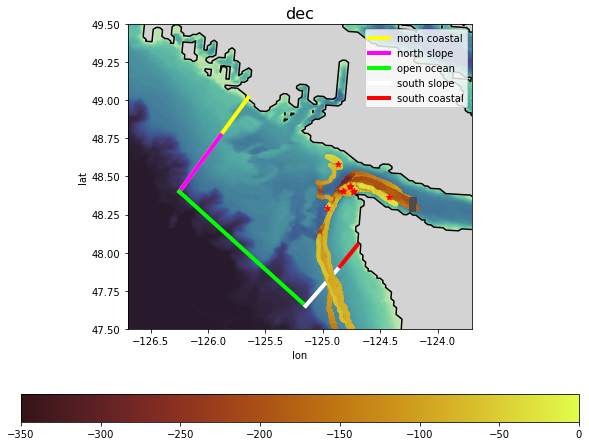

In [6]:
# winter boundaries
fig, ax = plt.subplots(figsize=(10,8))
plt_qual_2D('dec', ax)

#boundary lines

ax.plot([-126.25,-125.65],[48.4,49.02], c='yellow', linewidth=4, label='north coastal')
ax.plot([-126.25,-125.89],[48.4,48.77], c='magenta',linewidth=4, label='north slope')
ax.plot([-126.25,-125.15],[48.4,47.65], c='lime',linewidth=4, label='open ocean')
ax.plot([-124.85,-125.15],[47.91,47.65], c='w',linewidth=4, label='south slope')
ax.plot([-124.7,-124.85],[48.05,47.91], c='r',linewidth=4, label='south coastal')
ax.legend()

### based on previous conversations with Susan the winter boudnaries should be closer to shore, but based on what i'm seeing for the qualitative run I don't an incredibly strong case for needing this!

## same hting but in i,j space

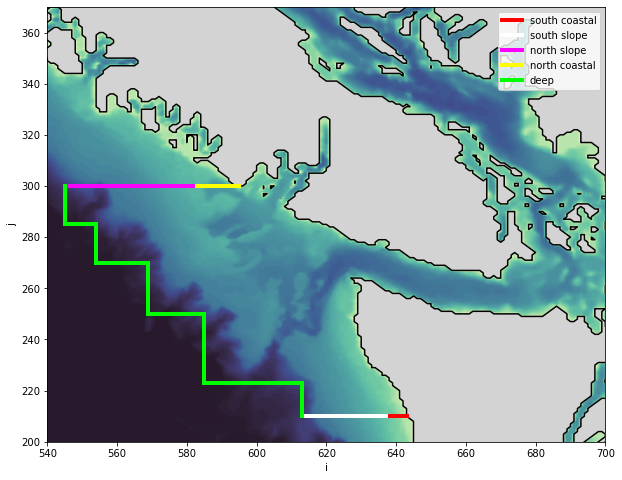

In [7]:
fig, ax = plt.subplots(figsize=(10,8))

#Depth
c = ax.contourf(
mesh.mbathy[0,:,:]*10, levels=np.arange(0, 500.1, 5),
cmap=cm.cm.deep, extend='max',
)
    
#.. everything else
ax.contourf(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([540, 700])
ax.set_ylim([200,370])
ax.set_xlabel('i')
ax.set_ylabel('j')

#boundary lines
ax.plot([613,643],[210,210], 'r',linewidth=4, label='south coastal')
ax.plot([613,637],[210,210], 'w',linewidth=4, label='south slope')
ax.plot([545,595],[300,300], 'magenta',linewidth=4, label='north slope')
ax.plot([583,595],[300,300], 'yellow',linewidth=4, label='north coastal')
ax.plot([545,545],[300,285], 'lime',linewidth=4, label='deep')
ax.plot([545,554],[285,285], 'lime',linewidth=4)
ax.plot([554,554],[285,270], 'lime',linewidth=4)
ax.plot([554,569],[270,270], 'lime',linewidth=4)
ax.plot([569,569],[270,250], 'lime',linewidth=4)
ax.plot([569,585],[250,250], 'lime',linewidth=4)
ax.plot([585,585],[250,223], 'lime',linewidth=4)
ax.plot([585,613],[223,223], 'lime',linewidth=4)
ax.plot([613,613],[223,210], 'lime',linewidth=4)
ax.legend()

## tracks with density instead of depth

In [20]:
def plt_tracers_2D(month, year, ax):
    
    n = 14 #number of particles being tracked
    
    if month == 'feb':
        file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/backward_28'+month+str(year)+'/ariane_trajectories_qualitative.nc')
    else:
        file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/backward_30'+month+str(year)+'/ariane_trajectories_qualitative.nc')
    
    # Bathymetry
    c = ax.contourf(
    mesh.nav_lon, mesh.nav_lat, mesh.mbathy[0,:,:]*10, levels=np.arange(0, 500.1, 5),
    cmap=cm.cm.deep, extend='max',zorder=0,
    )
    
    # "Mapping"
    ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
    ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',zorder=2)
    ax.set_xlim([-126.7, -123.7])
    ax.set_ylim([47.5, 49.5])
    ax.set_aspect(1/np.sin(np.deg2rad(49)))
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.set_title(month+' '+str(year), fontsize=16)
    
    # Particle trajectories and depth
    im = ax.scatter(file.traj_lon,file.traj_lat, c=file.traj_dens,vmin=23, vmax=28,cmap=cm.cm.amp, s=10,zorder=3)
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
    ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s', zorder=4) # start location
    
    # End locations
    last_point= [pd.DataFrame(file.traj_lat[:,i]).last_valid_index() for i in range(n)]
    for i in range(n):
        ax.scatter(file.traj_lon[last_point[i],i],file.traj_lat[last_point[i],i],color='r',marker='*', zorder=4)

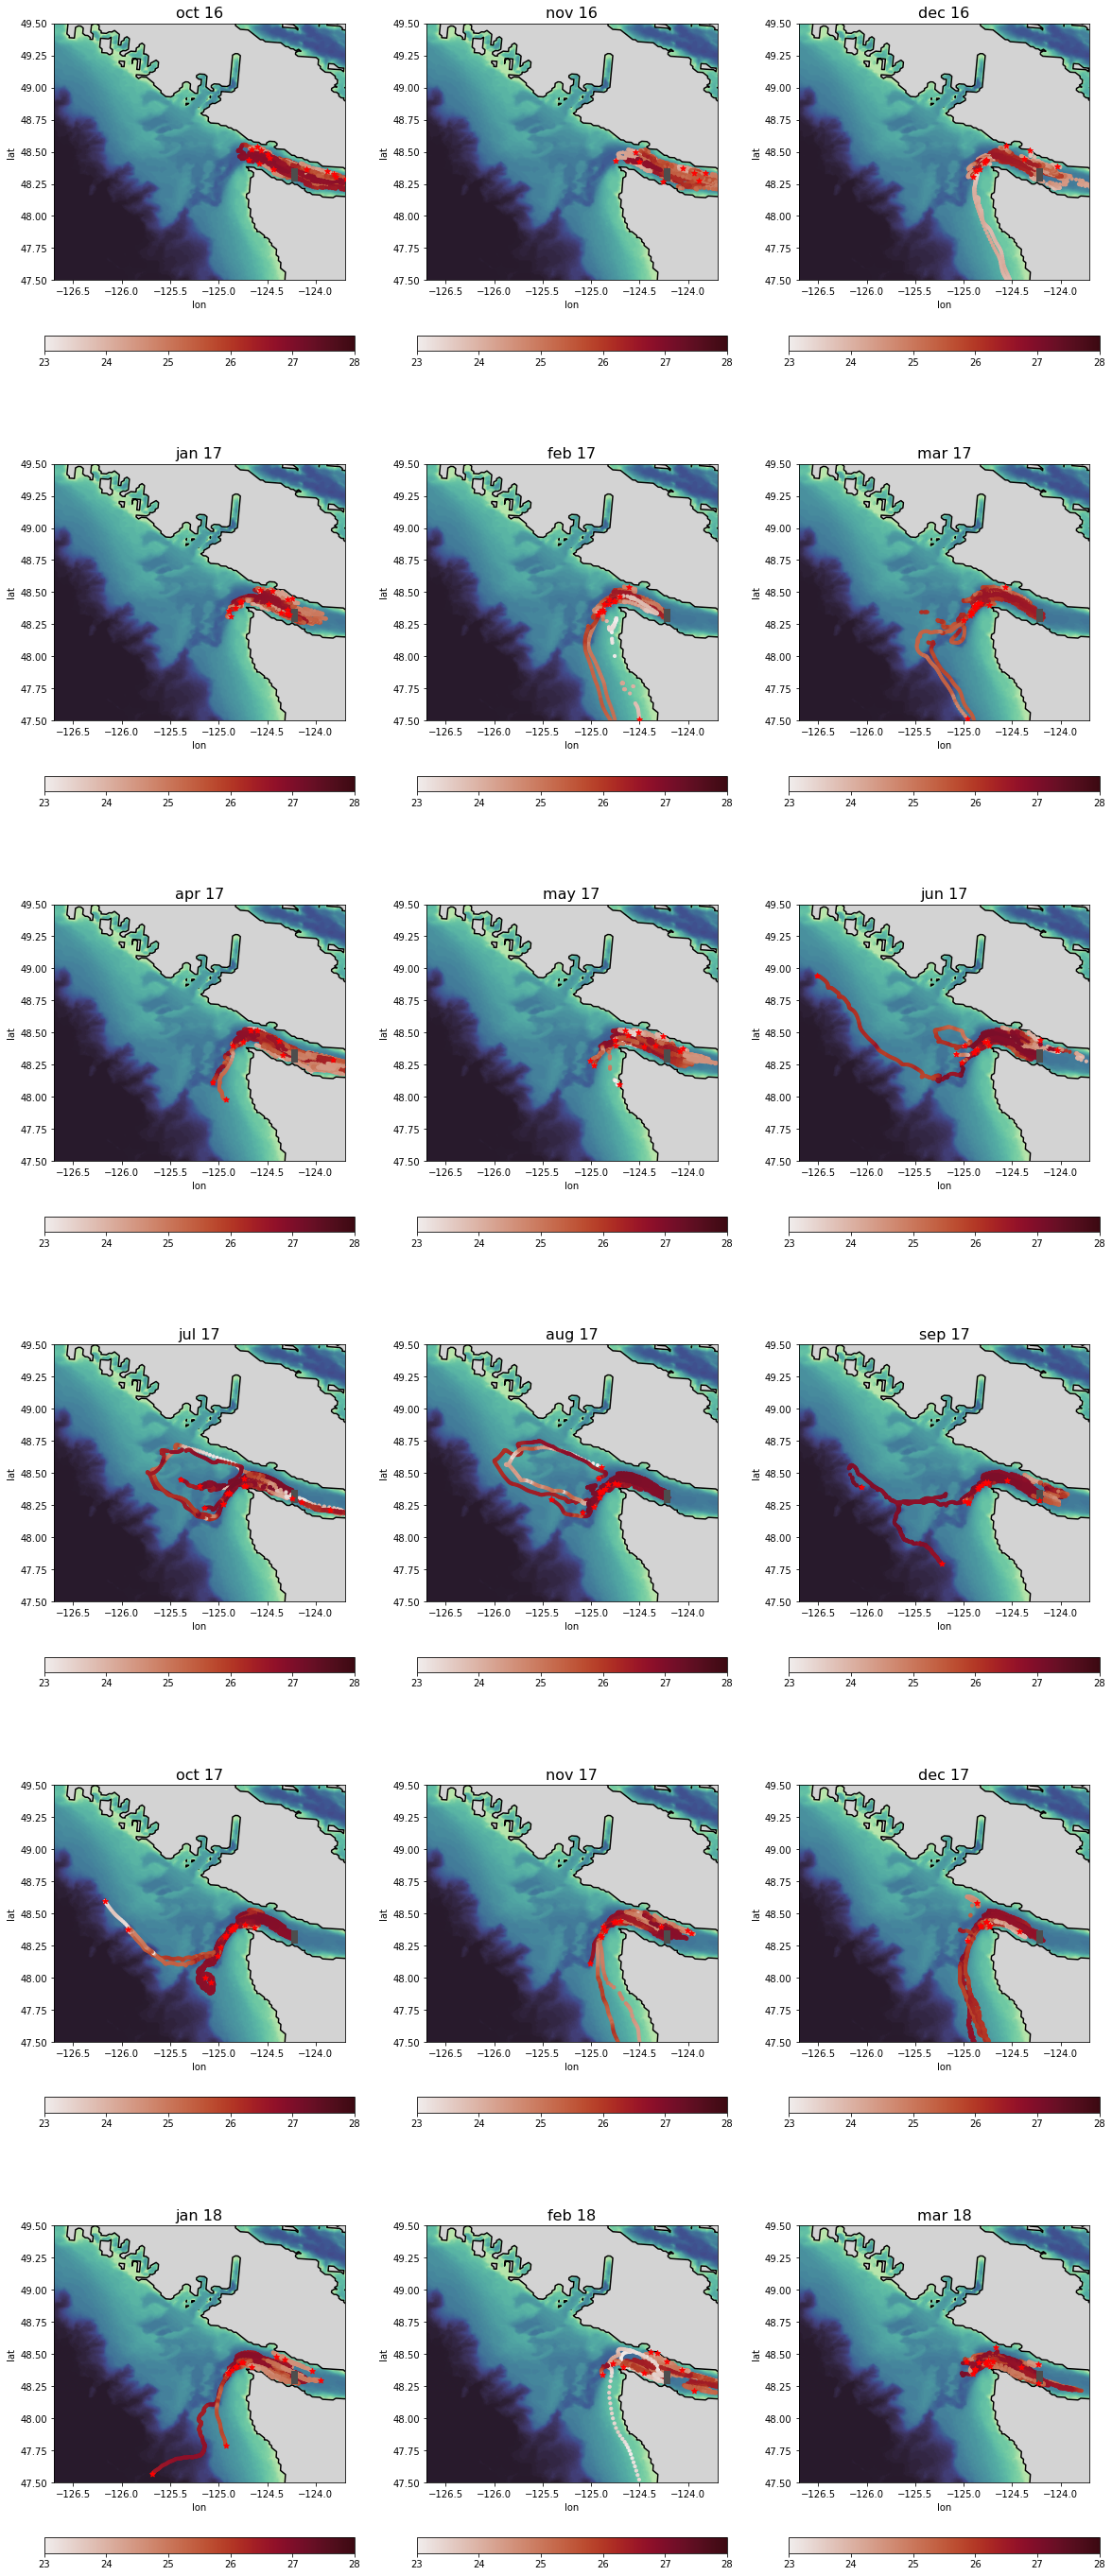

In [23]:
fig, ax = plt.subplots(6,3,figsize=(20, 50))

plt_tracers_2D('oct', 16, ax[0,0])
plt_tracers_2D('nov', 16, ax[0,1])
plt_tracers_2D('dec', 16, ax[0,2])

plt_tracers_2D('jan', 17, ax[1,0])
plt_tracers_2D('feb', 17, ax[1,1])
plt_tracers_2D('mar', 17, ax[1,2])
plt_tracers_2D('apr', 17, ax[2,0])
plt_tracers_2D('may', 17, ax[2,1])
plt_tracers_2D('jun', 17, ax[2,2])
plt_tracers_2D('jul', 17, ax[3,0])
plt_tracers_2D('aug', 17, ax[3,1])
plt_tracers_2D('sep', 17, ax[3,2])
plt_tracers_2D('oct', 17, ax[4,0])
plt_tracers_2D('nov', 17, ax[4,1])
plt_tracers_2D('dec', 17, ax[4,2])

plt_tracers_2D('jan', 18, ax[5,0])
plt_tracers_2D('feb', 18, ax[5,1])
plt_tracers_2D('mar', 18, ax[5,2])

In [10]:
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/backward_30dec17/ariane_trajectories_qualitative.nc')

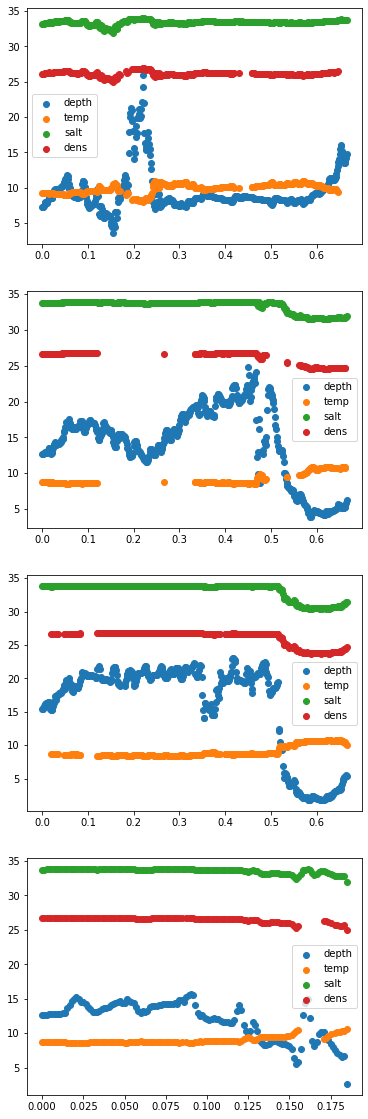

In [11]:
#weird gaps in density information due to gaps in salt information! 
#make sure this isnt because of how your doing the temp and salinity calcs

fig, ax = plt.subplots(4,1, figsize =(6,20))
for i in range(4):
    list=[0,2,3,6]
    ax[i].scatter(file.traj_time[:,list[i]], file.traj_depth[:,list[i]]/-10,label='depth')
    ax[i].scatter(file.traj_time[:,list[i]], file.traj_temp[:,list[i]],label='temp')
    ax[i].scatter(file.traj_time[:,list[i]], file.traj_salt[:,list[i]],label='salt')
    ax[i].scatter(file.traj_time[:,list[i]], file.traj_dens[:,list[i]], label='dens')
    ax[i].legend()

In [14]:
path = "/ocean/rbeutel/data/201712/"
files = [path + "T_new_201712{:02d}.nc".format(date+1) for date in range(30)]

for i in range(len(files)):
    print(np.count_nonzero(np.isnan(xr.open_dataset(files[0]).votemper)))

731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448
731723448


In [15]:
path = "/ocean/rbeutel/data/201712/"
files = [path + "T_new_201712{:02d}.nc".format(date+1) for date in range(30)]

for i in range(len(files)):
    print(np.max(xr.open_dataset(files[0]).votemper))

<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.DataArray 'votemper' ()>
array(13.88854077)
<xarray.Data

In [16]:
path = "/ocean/rbeutel/data/201712/"
files = [path + "T_new_201712{:02d}.nc".format(date+1) for date in range(30)]

for i in range(len(files)):
    print(np.min(xr.open_dataset(files[0]).votemper))

<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()>
array(-0.3197576)
<xarray.DataArray 'votemper' ()